# Scientific Figure Captioning

## Merge Figure and Caption Data

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
figures = pd.read_csv('figures.csv', index_col=0)
captions = pd.read_csv('captions.csv', index_col=0)

In [3]:
figures.head()

,file,feat,cluster
0,J75-4019-Figure14-1.png,[[0. 0. 0. ... 0. 0. 0.]],1
1,J75-4019-Figure9-1.png,[[0. 0. 0. ... 0. 0. 0.]],1
2,W08-0803-Figure5-1.png,[[0. 0. 0. ... 1.922831 0. ...,0
3,J75-4019-Figure6-1.png,[[0. 0. 0. ... 0. 0. 0.]],1
4,W08-0803-Figure4-1.png,[[0.49803656 0.7170737 1.1811514 ... 0. ...,1


In [4]:
captions.head()

,file,caption,clean text,num_words,num_sentence,subfigure
0,results/1987.mtsummit-1.14-Figure3-2-1.png,Figure 3-2 SENTENCE STRUCTURE,2 sentence structure,4,1,False
1,results/1987.mtsummit-1.14-Figure3-3-1.png,Figure 3-3 shows the flow of the syntactic and...,3 shows the flow of the syntactic and the sema...,27,2,False
2,results/1987.mtsummit-1.14-Figure3-7-1.png,Figure 3-7 GENERATION OF MORPHOLOGICAL INFORMA...,7 generation of morphological information,6,1,False
3,results/1987.mtsummit-1.14-Figure3-6-1.png,Figure 3-6 TYPICAL TRANSFER PROBLEM CAUSED BY ...,6 typical transfer problem caused by language ...,10,1,False
4,results/1987.mtsummit-1.14-Figure3-1-1.png,Figure 3-1 WORD STRUCTURE,1 word structure,4,1,False


Format the file name in the captions dataframe to match with the file name in the figure dataframe so they match. 

In [5]:
captions['file'] = captions.apply(lambda row: re.sub(r'^results/', '', row['file']), axis=1)

Now, select a cluster for the figures, and perform an inner join between the figures and the captions to generate our dataset to be used for training and testing. Choose cluster 0 for now due to it's clear separation and pattern.

In [13]:
cluster = figures[(figures['cluster'] == 1) | (figures['cluster'] == 2)]

In [14]:
# Perform inner join
data = pd.merge(cluster, captions, on='file')

In [15]:
data

,file,feat,cluster,caption,clean text,num_words,num_sentence,subfigure
0,J75-4019-Figure14-1.png,[[0. 0. 0. ... 0. 0. 0.]],1,Figure 14: The r e l a t i v e clause generator .,: the r e l a t i v e clause generator .,14,1,False
1,J75-4019-Figure9-1.png,[[0. 0. 0. ... 0. 0. 0.]],1,Figure 9: Generating the s u r f a c e o b j e...,generating the s u r f a c e o b j e c t .,18,1,False
2,J75-4019-Figure6-1.png,[[0. 0. 0. ... 0. 0. 0.]],1,Figure 6: Generation of subject of sub ject-ve...,generation of subject of sub ject-verb-ob ject...,10,1,False
3,W08-0803-Figure4-1.png,[[0.49803656 0.7170737 1.1811514 ... 0. ...,1,Figure 4. The FSA for checking label completion,the fsa for checking label completion,8,1,False
4,J75-4011-Figure1-1.png,[[0. 0. 0. ... 0. 0. 0.]],1,Fig. 1: Adaptive System Overview,adaptive system overview,5,1,False
...,...,...,...,...,...,...,...,...
45497,P19-3023-Figure1-1.png,[[0. 0. 0. ... 0. ...,1,Figure 1: Overview of our approach,overview of our approach,6,1,False
45498,P19-3027-Figure1-1.png,[[0. 0. 0. ... 0. 0. 0.]],1,Figure 1: Examples of model architectures in r...,examples of model architectures in recent text...,118,3,True
45499,P19-3028-Figure5-1.png,[[1.0749899 0. 0.63658386 ... 0. ...,1,Figure 5: Two polar views of countries and foods.,two polar views of countries and foods.,9,1,False
45500,P19-3028-Figure14-1.png,[[0. 2.2118642 0.8708761 ... 0. ...,1,Figure 14: Two polar view of countries and foo...,: two polar view of countries and foods in wik...,11,1,False


In [16]:
# Remove figures with subfigures
data.drop(data[data['subfigure'] == True].index, inplace=True)

*** 
Exploration

## Pre-process Text

In [17]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [18]:
# Append <start> and <end> token to each caption
def start_end(text):
    text = f'<start> {text} <end>'
    return text

data['clean text'] = data.apply(lambda row: start_end(row['clean text']), axis=1)

In [19]:
# Function for creating a tokenizer
def create_tokenizer(data):
    
    tokenizer = Tokenizer()
    
    # Fit tokenizer on text
    tokenizer.fit_on_texts(data['clean text'])
    
    # Get size of vocab
    vocab_size = len(tokenizer.word_index) + 1
    
    return (tokenizer, vocab_size)

# Function for padding sequence
def pad_text(text, max_length):
    text = pad_sequences([text], maxlen=max_length, padding='post')[0]
    
    return text

In [20]:
tokenizer, vocab_size = create_tokenizer(data)

In [21]:
def tokenize_text(text):
    
    # Convert caption to list of word indices
    word_idxs = tokenizer.texts_to_sequences([text])[0]
    
    # Pad output to fixed length
    pad_idxs = pad_text(word_idxs, 50)
    
    return pad_idxs

In [22]:
data['tokenized'] = data.apply(lambda row: tokenize_text(row['caption']), axis=1)

In [23]:
data.head()

,file,feat,cluster,caption,clean text,num_words,num_sentence,subfigure,tokenized
0,J75-4019-Figure14-1.png,[[0. 0. 0. ... 0. 0. 0.]],1,Figure 14: The r e l a t i v e clause generator .,<start> : the r e l a t i v e clause generator...,14,1,False,"[43, 1510, 1, 198, 83, 256, 6, 75, 68, 297, 83..."
1,J75-4019-Figure9-1.png,[[0. 0. 0. ... 0. 0. 0.]],1,Figure 9: Generating the s u r f a c e o b j e...,<start> generating the s u r f a c e o b j e c...,18,1,False,"[43, 591, 702, 1, 103, 450, 198, 145, 6, 100, ..."
2,J75-4019-Figure6-1.png,[[0. 0. 0. ... 0. 0. 0.]],1,Figure 6: Generation of subject of sub ject-ve...,<start> generation of subject of sub ject-verb...,10,1,False,"[43, 263, 250, 4, 405, 4, 364, 9708, 207, 2796..."
3,W08-0803-Figure4-1.png,[[0.49803656 0.7170737 1.1811514 ... 0. ...,1,Figure 4. The FSA for checking label completion,<start> the fsa for checking label completion ...,8,1,False,"[43, 84, 1, 1901, 8, 3349, 192, 1725, 0, 0, 0,..."
4,J75-4011-Figure1-1.png,[[0. 0. 0. ... 0. 0. 0.]],1,Fig. 1: Adaptive System Overview,<start> adaptive system overview <end>,5,1,False,"[451, 21, 1978, 39, 138, 0, 0, 0, 0, 0, 0, 0, ..."


***

## Prepare Training Data with Tensorflow Dataset

In [24]:
import tensorflow as tf
from PIL import Image
import os
tf.compat.v1.enable_eager_execution()

os.chdir('/data/bxc5446/pdffigures2/target/scala-2.11/results')

In [25]:
train_captions = data['clean text'].values.tolist()
img_name_vector = data['file'].values.tolist()

<start> : the r e l a t i v e clause generator . <end>


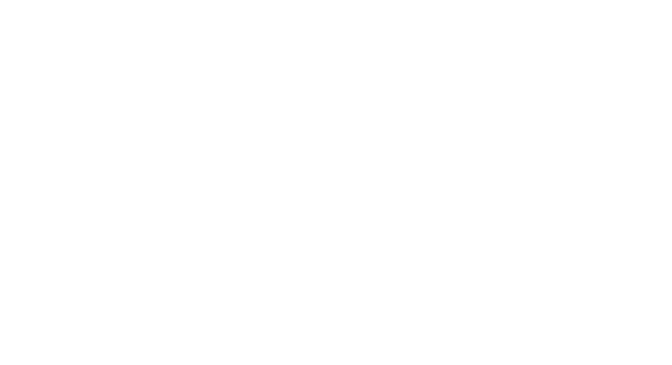

In [26]:
print(train_captions[0])
Image.open(img_name_vector[0])

### Process image using Inception V3

In [27]:
from tqdm import tqdm

In [28]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [29]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [30]:
image_dataset = tf.data.Dataset.from_tensor_slices(img_name_vector)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode('utf-8')
        np.save(path_of_feature, bf.numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2755/2755 [06:03<00:00,  7.57it/s]


In [31]:
#train_captions = np.array(train_captions)
#train_captions = np.reshape(train_captions, (len(train_captions), 1))
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [32]:
# Turn the tokenized texts into a tensorflow dataset
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [33]:
word_to_index = tf.keras.layers.experimental.preprocessing.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.experimental.preprocessing.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

### Split the data into training and testing

In [34]:
import collections
import random

In [35]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

In [36]:
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

In [37]:
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

In [38]:
img_name_train = []
cap_train = []

for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])
    
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [39]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(35252, 35252, 8813, 8813)

### Create a tf.data dataset for training

In [40]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train)

features_shape = 2048
attention_features_shape = 64

In [41]:
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [42]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int64]), num_parallel_calls=tf.data.AUTOTUNE)

In [43]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

### Model

In [44]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [45]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [46]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [47]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, 5000)

In [48]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [49]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [50]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

### Training

In [51]:
import time

In [52]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [53]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
          # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

          # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [54]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 8 Batch 0 Loss 2.4147
Epoch 8 Batch 100 Loss 1.7240
Epoch 8 Batch 200 Loss 1.4059
Epoch 8 Batch 300 Loss 1.7922
Epoch 8 Batch 400 Loss 1.7454
Epoch 8 Batch 500 Loss 1.8985
Epoch 8 Loss 0.027861
Time taken for 1 epoch 251.44 sec

Epoch 9 Batch 0 Loss 1.7223
Epoch 9 Batch 100 Loss 1.6406
Epoch 9 Batch 200 Loss 1.6609
Epoch 9 Batch 300 Loss 1.7721
Epoch 9 Batch 400 Loss 1.5104
Epoch 9 Batch 500 Loss 1.5149
Epoch 9 Loss 0.025439
Time taken for 1 epoch 144.34 sec

Epoch 10 Batch 0 Loss 1.4900
Epoch 10 Batch 100 Loss 1.6673
Epoch 10 Batch 200 Loss 1.5968
Epoch 10 Batch 300 Loss 1.3459
Epoch 10 Batch 400 Loss 1.4738
Epoch 10 Batch 500 Loss 1.4338
Epoch 10 Loss 0.024106
Time taken for 1 epoch 146.11 sec

Epoch 11 Batch 0 Loss 1.3954
Epoch 11 Batch 100 Loss 1.5272
Epoch 11 Batch 200 Loss 1.5505
Epoch 11 Batch 300 Loss 1.4554
Epoch 11 Batch 400 Loss 1.2378
Epoch 11 Batch 500 Loss 1.2557
Epoch 11 Loss 0.023181
Time taken for 1 epoch 146.06 sec

Epoch 12 Batch 0 Loss 1.2890
Epoch 12 Batch 10

In [55]:
import matplotlib.pyplot as plt

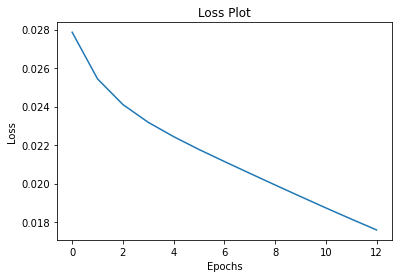

In [56]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [57]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [58]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> comparison of the manually created questions from [UNK] [UNK] [UNK] the new basque [UNK] and german [UNK] data sets. only expert annotations were considered and only cases in which the respective labels were found to be [UNK] were taken into [UNK] <end>
Prediction Caption: average [UNK] representational similarity <end>


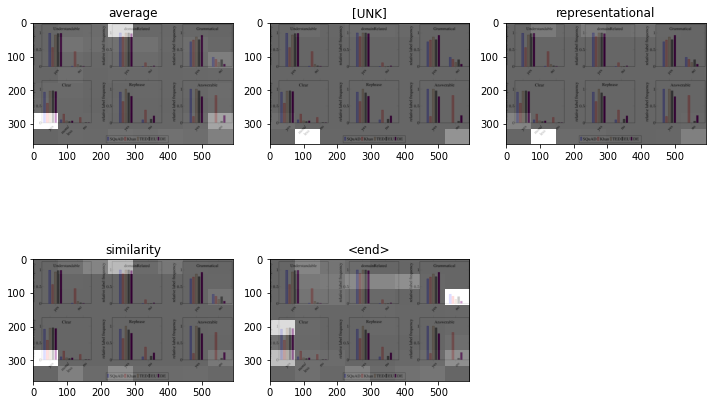

Real Caption: <start> statistics related to the collected multimodal questions. <end>
Prediction Caption: distribution of [UNK] accuracy across five turns on the ratio compared to the [UNK] article in descending order of 100 hits found in each pair distribution in the temporal dataset as two test sets. <end>


/tmp/ipykernel_142326/3853974765.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


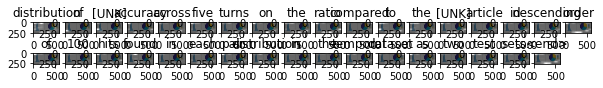

Real Caption: <start> times of event words that are predicted correctly in [UNK] [UNK] set in unsupervised setting (only shows most frequent 15 event words) <end>
Prediction Caption: news test for expert segment selection. <end>


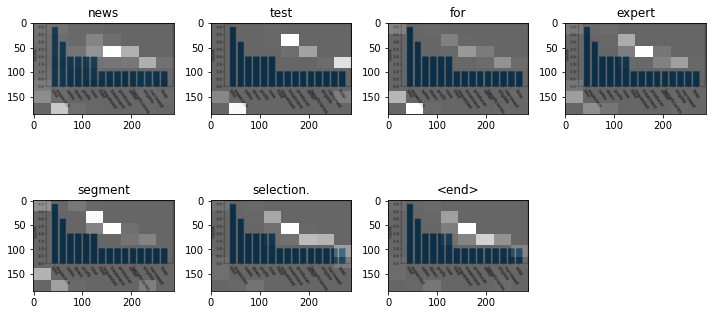

Real Caption: <start> building a classifier for structured sentences. <end>
Prediction Caption: co-training framework architecture <end>


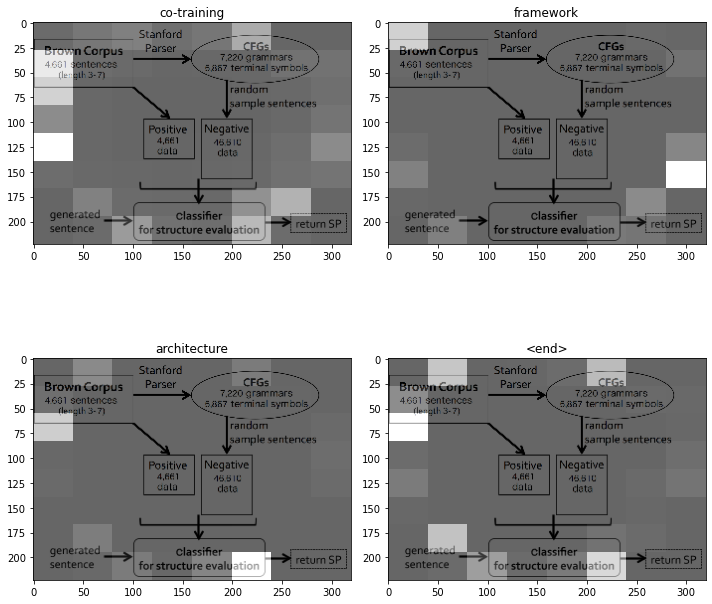

Real Caption: <start> our mention [UNK] model with the edge representation encoding two phrases. <end>
Prediction Caption: two-stage sequential training. <end>


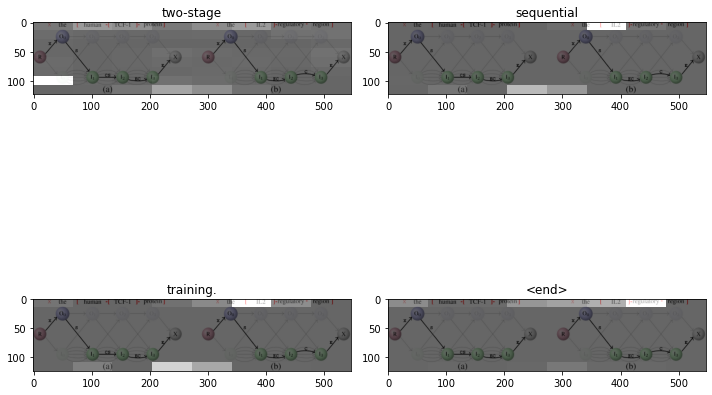

Real Caption: <start> standard sequence to sequence model. <end>
Prediction Caption: the structure of the rules it into word (or the neural network is not used for relation extraction. <end>


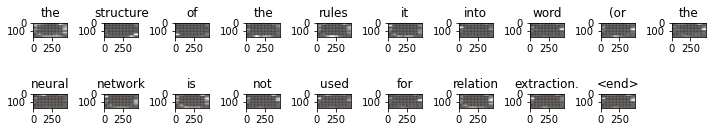

Real Caption: <start> a [UNK] used in fig. 1 <end>
Prediction Caption: a sample session of a [UNK] semantic parses of gesture with a part of an input in a web sentence in the new [UNK] [UNK] with [UNK] <end>


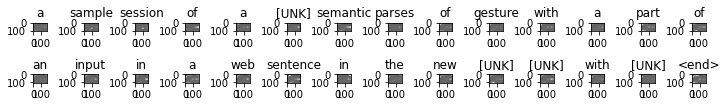

Real Caption: <start> [UNK] data workflow <end>
Prediction Caption: [UNK] and layer output of the question and a question with [UNK] [UNK] [UNK] <end>


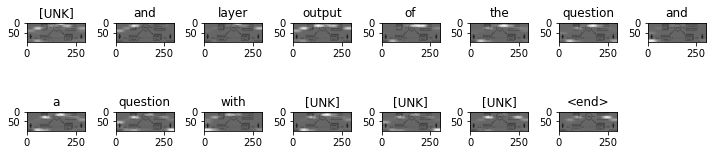

Real Caption: <start> parse tree <end>
Prediction Caption: example of speech of [UNK] modifier or nt label or common [UNK] [UNK] nodes of the sentence “john [UNK] [UNK] is bolded probability vector is constructed tree for the sentence <end>


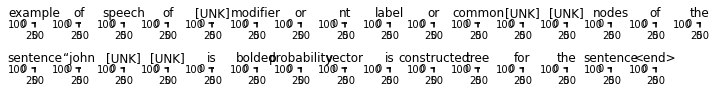

Real Caption: <start> example cases with the prediction results of [UNK] and [UNK] the symbol [UNK] denotes a correct prediction and × denotes a wrong prediction. <end>
Prediction Caption: example sentence with condition [UNK] makes there is only indicate the row [UNK] and are sorted by [UNK] [UNK] [UNK] across possible [UNK] train for the source transcript represent false [UNK] <end>


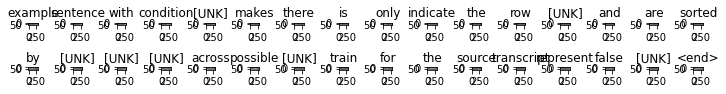

In [59]:
# captions on the validation set
for i in range(10):
    rid = np.random.randint(0, len(img_name_val))
    image = img_name_val[rid]
    real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                             for i in cap_val[rid] if i not in [0]])
    result, attention_plot = evaluate(image)

    print('Real Caption:', real_caption)
    print('Prediction Caption:', ' '.join(result))
    plot_attention(image, result, attention_plot)

In [60]:
from nlgeval import compute_individual_metrics
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
i = 0
bleu = []
meteor = []
rouge = []
cider = []
eacs = []

for img in tqdm(img_name_val[0:100]):
    result, _ = evaluate(img)
    result = ' '.join(result)
    
    real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[i] if i not in [0]])
    
    scores = compute_individual_metrics(real_caption, result)
    bleu.append(scores['Bleu_4'])
    meteor.append(scores['METEOR'])
    rouge.append(scores['ROUGE_L'])
    cider.append(scores['CIDEr'])
    eacs.append(scores['EmbeddingAverageCosineSimilarity'])
                        
    
    i += 1

 18%|██████████████████▋                                                                                     | 18/100 [11:19<51:18, 37.55s/it]

In [ ]:
bleu_avg = sum(bleu) / len(bleu)
meteor_avg = sum(meteor) / len(meteor)
rouge_avg = sum(rouge) / len(rouge)
cider_avg = sum(cider) / len(cider)
eacs_avg = sum(eacs) / len(eacs)

print(f'Bleu: {bleu_avg}')
print(f'Meteor: {meteor_avg}')
print(f'Rouge: {rouge_avg}')
print(f'Cider: {cider_avg}')
print(f'EACS: {eacs_avg}')